##### Author:
    Diana Y. Lee, Luque Lab, SDSU
    dlee@sdsu.edu

##### Purpose:
    Creates an algorithm to assess T-number of a phage based on similarity of MCP
    Assesses the accuracy of that algorithm
    Creates the base illustrations for Figure 4 and related SI of the paper in preparation titled, [TBD]

##### Requires: 
    phage_functions.ipynb 
    data\PHAGE_TABLE1.xlsx : phage data with indexes, genome size, and translations
    data\MCPdbblastpe001.csv : Similarity table from blastp (e value = 0.001)
    data\PhageTable_Remove.xlsx : lists the phages that needed to be pulled from the data after verifying the MCPs
    
##### Database file: 
    item3_update.db
    
##### Creates:
    Fig4a-Tdist vs Similarity(e.001).png
    Fig4a-Tdist vs Similarity(e.001) violin.png
    Fig4SI-Tnum vs Similarity.png
    Fig4c-Similarity vs accuracy and predictions.svg
    Fig4d-Similarity percent per T.svg
    Fig4d-Similarity percent per T violin.svg    

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(8)
import math
import copy
import csv
import time
import seaborn as sn

In [2]:
from ipynb.fs.full.phage_functions import tNearest
from ipynb.fs.full.phage_functions import tNearestValid
from ipynb.fs.full.phage_functions import tModel
from ipynb.fs.full.phage_functions import tNum
from ipynb.fs.full.phage_functions import tList

In [3]:
# set the fontsize
font1 = 22
font2 = 18
font3 = 14

In [4]:
#create a list of possible, valid T-numbers, as well as separate t-number lists for T_h and T_t 
tps2, tps, tps_t, tps_h = tList(7)

In [5]:
# error margin
errMar = 0.09

In [6]:
# function to clean up an NCBI alignment text file

def newAlign(sim_table):
    
    # rename the columns
    sim_table.columns = ['query from', 'query to', 'percent identity', 'alignment length','mismatches', 'gap opens', 'query start', 'query end', 's start', 's end', 'evalue', 'bit score', 'percent positives']
    # create a boolean for each line that is true if it starts with 'ph'
    is_ph =  sim_table['query from']>'ph'
    # create a new table based on that boolean filter
    sim_ph = sim_table[is_ph]
    # create a boolean for each line that compares to itself
    is_nxn =  sim_table['query from']!=sim_table['query to']
    # apply the second filter
    sim_ph = sim_ph[is_nxn]
    # strip the 'ph' from the table
    sim_ph["query from"] = sim_ph["query from"].map(lambda x: x.lstrip('ph'))
    sim_ph["query to"] = sim_ph["query to"].map(lambda x: x.lstrip('ph'))

    print(sim_ph.shape)
    return sim_ph
    #print(sim_ph.head())

In [7]:
# function to create a matrix of pairwise percent similarity (nxn)

def pairwiseMatrix(sim_table,nn):
    sLines = len(sim_table)
    tProx = np.zeros((nn,nn))

    for i in range(sLines):
        jVal = int(np.asarray(sim_table["query from"])[i])
        kVal = int(np.asarray(sim_table["query to"])[i])
        
        simVal = round(np.asarray(sim_table["percent identity"])[i],3)

        if (simVal>tProx[jVal][kVal]):
            tProx[jVal][kVal] = round(np.asarray(sim_table["percent identity"])[i],3)
        if (simVal>tProx[kVal][jVal]):
            tProx[kVal][jVal] = round(np.asarray(sim_table["percent identity"])[i],3)

# now do it again for to-from, since there isn't symmetry in the results
    for i in range(sLines):
        jVal = int(np.asarray(sim_table["query to"])[i])
        kVal = int(np.asarray(sim_table["query from"])[i])
        
        simVal = round(np.asarray(sim_table["percent identity"])[i],3)

        if (simVal>tProx[jVal][kVal]):
            tProx[jVal][kVal] = round(np.asarray(sim_table["percent identity"])[i],3)
        if (simVal>tProx[kVal][jVal]):
            tProx[kVal][jVal] = round(np.asarray(sim_table["percent identity"])[i],3)
           
            
    return tProx

In [8]:
# function to separate the similarity table into 20% increments

def Percentile20(tProx, Tij, n2):

    allResults01 = []
    Series01 = []
    Series02 = []
    Series03 = []
    Series04 = []
    Series05 = []

    for i in range(n2):
        for j in range(n2):
            if i < j:
                allResults01.append(i);
                allResults01.append(j);
                allResults01.append(tProx[i][j]);
                allResults01.append(Tij[i][j]);
                if(tProx[i][j] <= 20.0):
                    Series01.append(Tij[i][j]);
                if(tProx[i][j] > 20.0 and tProx[i][j]<=40.0):
                    Series02.append(Tij[i][j]);
                if(tProx[i][j] > 40.0 and tProx[i][j]<=60.0):
                    Series03.append(Tij[i][j]);
                if(tProx[i][j] > 60.0 and tProx[i][j]<=80.0):
                    Series04.append(Tij[i][j]);
                if(tProx[i][j] > 80.0 and tProx[i][j]<=100.0):
                    Series05.append(Tij[i][j]);


    allResults01 = np.asarray(allResults01);
    Series01 = np.asarray(Series01);
    Series02 = np.asarray(Series02);
    Series03 = np.asarray(Series03);
    Series04 = np.asarray(Series04);
    Series05 = np.asarray(Series05);

    plotData = [Series01,Series02,Series03,Series04,Series05]

    from scipy.special import comb
    nn = (int)(comb(n2,2));

    allResults = np.reshape(np.ravel(allResults01), (nn, 4));
    allResults = np.asarray(allResults);
    
    return allResults, plotData

In [9]:
# import phage data
phageData = pd.read_excel("data\PHAGE_TABLE1.xlsx")
n = len(phageData)

# isolate the genome size
genomebps = np.asarray(phageData["COMPLETE_GENOME_BP"])

# create T number table for raw T number
tRaw = np.zeros((n))
for i in range(n):
    tRaw[i] = tNum(genomebps[i]/1000,0)

# create T number table for nearest valid T number
tNear = np.zeros((n))
for i in range(n):
    tNear[i] = tNum(genomebps[i]/1000,1)

# create T number table for nearest valid T number within error margin
tNearV = np.zeros((n))
for i in range(n):
    tNearV[i] = tNum(genomebps[i]/1000,2,errMar)
    
# isolate the MCP translation data
translation=np.asarray(phageData["TRANSLATION"])

# import blastp hit table with an e value = 0.001
sim_e001 = pd.read_csv("data\MCPdbblastpe001.csv")

# clean up the tables
sim_ph_e001 = newAlign(sim_e001)

# create pairwise similarity matrices
tProx_e001 = pairwiseMatrix(sim_ph_e001,n)

# create a matrix of pairwise difference in T-number (nxn)
Tij_dist = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        Tij_dist[i][j]=abs(tRaw[i]-tRaw[j]);

# create a matrix of pairwise *average relative* difference in T-number (nxn)
Tij_dist2 = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        Tij_dist2[i][j]=0.5*((abs(tRaw[i]-tRaw[j])/tRaw[i])+(abs(tRaw[i]-tRaw[j])/tRaw[j]));

<ipython-input-6-d1701fe3f07f>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sim_ph = sim_ph[is_nxn]


(22035, 13)


In [10]:
ph_num = np.arange(0,n)

In [11]:
Tij_distDF2 = pd.DataFrame(Tij_dist2, columns=[ph_num])

Tij_distDF2[:5]

,0,1,2,3,4,5,6,7,8,9,...,659,660,661,662,663,664,665,666,667,668
0,0.000000,0.415724,0.168131,0.156876,1.680796,0.128310,0.289611,0.412925,1.568309,1.644238,...,0.269183,0.098762,0.261789,0.256341,0.305282,0.572481,0.725925,0.224651,0.022685,0.480278
1,0.415724,0.000000,0.239478,0.250916,1.007190,0.280175,0.119167,0.002586,0.925188,0.980621,...,0.139005,0.310789,0.146223,0.151555,0.104053,0.140953,0.272444,0.182794,0.391264,0.058942
2,0.168131,0.239478,0.000000,0.011109,1.375560,0.039398,0.118636,0.236820,1.277598,1.343756,...,0.098846,0.068800,0.091667,0.086373,0.133776,0.386784,0.528354,0.055483,0.145171,0.300503
3,0.156876,0.250916,0.011109,0.000000,1.394538,0.028282,0.129830,0.248251,1.295701,1.362447,...,0.110015,0.057669,0.102828,0.097529,0.144992,0.398719,0.540951,0.066613,0.133954,0.312121
4,1.680796,1.007190,1.375560,1.394538,0.000000,1.443629,1.183450,1.010863,0.059010,0.018845,...,1.214164,1.495816,1.225436,1.233794,1.160311,0.817090,0.657219,1.283319,1.636862,0.925280


In [12]:
Tij_distDF = pd.DataFrame(Tij_dist, columns=[ph_num])

Tij_distDF[:5]

,0,1,2,3,4,5,6,7,8,9,...,659,660,661,662,663,664,665,666,667,668
0,0.000000,2.615884,0.955545,0.887039,13.830068,0.716051,1.734693,2.595583,12.737600,13.473974,...,1.598707,0.543574,1.549971,1.514230,1.840330,3.801678,5.044199,1.309134,0.120341,3.092895
1,2.615884,0.000000,1.660339,1.728845,11.214184,1.899834,0.881191,0.020301,10.121715,10.858090,...,1.017177,2.072310,1.065913,1.101655,0.775554,1.185793,2.428314,1.306750,2.495543,0.477011
2,0.955545,1.660339,0.000000,0.068506,12.874523,0.239495,0.779148,1.640038,11.782054,12.518429,...,0.643162,0.411971,0.594426,0.558684,0.884784,2.846132,4.088653,0.353589,0.835204,2.137350
3,0.887039,1.728845,0.068506,0.000000,12.943029,0.170988,0.847654,1.708544,11.850561,12.586935,...,0.711668,0.343465,0.662932,0.627191,0.953291,2.914639,4.157160,0.422095,0.766698,2.205856
4,13.830068,11.214184,12.874523,12.943029,0.000000,13.114017,12.095375,11.234485,1.092468,0.356094,...,12.231361,13.286494,12.280097,12.315838,11.989738,10.028390,8.785869,12.520934,13.709726,10.737173


In [13]:
tProx_e001DF = pd.DataFrame(tProx_e001, columns=[ph_num])
tProx_e001DF[:5]

,0,1,2,3,4,5,6,7,8,9,...,659,660,661,662,663,664,665,666,667,668
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,99.054,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.344,0.0,0.0,23.047,27.068,0.0,0.0,0.0,0.000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0


In [14]:
phages_toRemove = pd.read_excel("data\PhageTable_Remove.xlsx")
len(phages_toRemove)

52

In [15]:
# remove the phages from both the similarity and T-difference dataframes
for i in range(len(phages_toRemove['phage_num'])):
    rmP = phages_toRemove.iloc[i]['phage_num']
    tProx_e001DF = tProx_e001DF.drop([rmP], axis=1).drop([rmP], axis=0)
    Tij_distDF = Tij_distDF.drop([rmP], axis=1).drop([rmP], axis=0)
    Tij_distDF2 = Tij_distDF2.drop([rmP], axis=1).drop([rmP], axis=0)
print(Tij_distDF.shape)
print(Tij_distDF2.shape)
print(tProx_e001DF.shape)

(617, 617)
(617, 617)
(617, 617)


In [16]:
# break up both table into 20 percentile increments
n = len(phageData)-len(phages_toRemove)
all_e001, plotdata_e001 = Percentile20(np.asarray(tProx_e001DF), np.asarray(Tij_distDF2), n)

In [17]:
# create a truncated t list with zero at the end
tps3 = tps[:21]
tps3 = np.insert(tps3,21,0)
tps3

array([ 1.  ,  1.33,  3.  ,  4.  ,  5.33,  7.  ,  9.  ,  9.33, 12.  ,
       13.  , 16.  , 17.33, 19.  , 21.  , 21.33, 25.  , 25.33, 27.  ,
       28.  , 31.  , 33.33,  0.  ])

In [33]:
# create an x-label list for plotting
tps4 = []
tps4.append(" ")
for i in tps[:21]:
    tps4.append(i)
tps4.append('No T')
tps4 = np.asarray(tps4)

In [34]:
# determine how many pairings there should be
# comb is N choose k
from scipy.special import comb
nn = (int)(comb(n,2, repetition=False))

# so if we were to leave out duplicated numbers, we expect this many pairwise entries
nn

190036

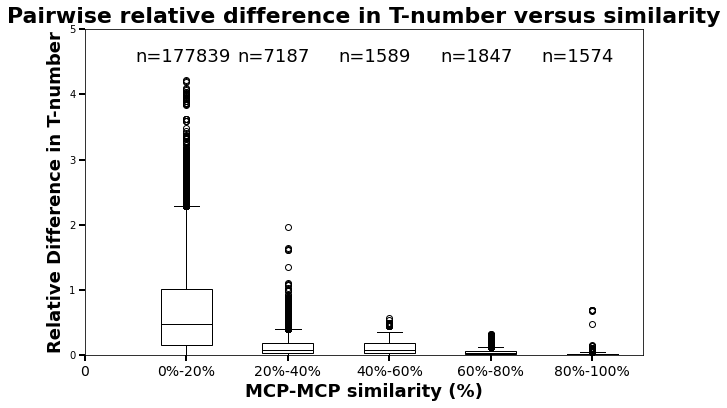

In [35]:
# box plot for evalue=0.001
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.boxplot(plotdata_e001, patch_artist=True, boxprops=dict(facecolor='white'), medianprops = dict(color="black"))
plt.xlabel("MCP-MCP similarity (%)",fontweight="bold", fontsize=font2) 
plt.ylabel("Relative Difference in T-number",fontweight="bold", fontsize=font2)
plt.title("Pairwise relative difference in T-number versus similarity",fontweight="bold", fontsize=font1)
plt.ylim(0,5)
plt.xticks(np.arange(6), ('0','0%-20%','20%-40%','40%-60%', '60%-80%', '80%-100%'), fontsize=font3)
ax.patch.set_facecolor('white')
ax.tick_params(length=6, width=2)

allplotdatan = 0
plotdatan = []
for i in range(len(plotdata_e001)):
    DNAfb = "n=" + str(len(plotdata_e001[i]))
    plotdatan.append(DNAfb)
    allplotdatan = allplotdatan+len(plotdata_e001[i])
    plt.text(i+1-.5, 4.5, DNAfb, {'fontsize': font2})


#plt.savefig("Fig4a-Tdist vs Similarity(e.001).png")
#plt.savefig("Fig4a-Tdist vs Similarity(e.001).svg");

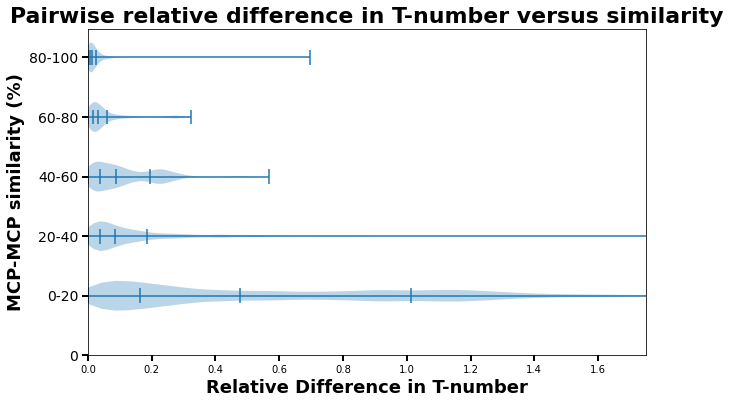

In [81]:
# box plot for evalue=0.001ad
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.violinplot(plotdata_e001,quantiles=[[.25,.5,.75], [.25,.5,0.75], [.25,.5,0.75], [.25,.5,0.75], [.25,.5,0.75]], vert=False)
plt.ylabel("MCP-MCP similarity (%)",fontweight="bold", fontsize=font2) 
plt.xlabel("Relative Difference in T-number",fontweight="bold", fontsize=font2)
plt.title("Pairwise relative difference in T-number versus similarity",fontweight="bold", fontsize=font1)
plt.xlim(0,1.75)
plt.yticks(np.arange(6), ('0','0-20','20-40','40-60', '60-80', '80-100'), fontsize=font3)
#ax.patch.set_facecolor('white')
ax.tick_params(length=6, width=2)

#allplotdatan = 0
#plotdatan = []
#for i in range(len(plotdata_e001)):
#    DNAfb = "n=" + str(len(plotdata_e001[i]))
#    plotdatan.append(DNAfb)
#    allplotdatan = allplotdatan+len(plotdata_e001[i])
#    plt.text(i+1-.5, .5, DNAfb, {'fontsize': font2})


plt.savefig("Fig4a-Tdist vs Similarity(e.001) violin.png")
plt.savefig("Fig4a-Tdist vs Similarity(e.001) violin.svg");

In [4]:
test_df = pd.DataFrame(plotdata_e001)

print("total 0-20% similarity: ", len(test_df.iloc[0]))
print("total 0-20% similarity with less than 9% difference in T-number: ", len(test_df.iloc[0][test_df.iloc[0]<=.09]))
print("percent 0-20% similarity with less than 9% difference in T-number: ", len(test_df.iloc[0][test_df.iloc[0]<=.09])/len(test_df.iloc[0]))

total 0-20% similarity:  177839
total 0-20% similarity with less than 9% difference in T-number:  25519
percent 0-20% similarity with less than 9% difference in T-number:  0.1434949589235207


In [19]:
25519/177839

0.1434949589235207

In [ ]:
aP_MCPs = all_PHANNS[all_PHANNS['Max_Score_ID'] == 'Major capsid'] 

In [40]:
SN_plotdata_e001 = []
for i in range(len(plotdata_e001)):
    for j in range(len(plotdata_e001[i])):
        SN_plotdata_e001.append(plotdata_e001[i][j])
        SN_plotdata_e001.append(i)
        
SN_plotdata_e001 = np.reshape(np.ravel(SN_plotdata_e001), (-1, 2));
SN_plotdata_e001 = np.asarray(SN_plotdata_e001);
SN_plotdata_e001 = pd.DataFrame(SN_plotdata_e001, columns=["relative_difference","Similiarity_bracket"])

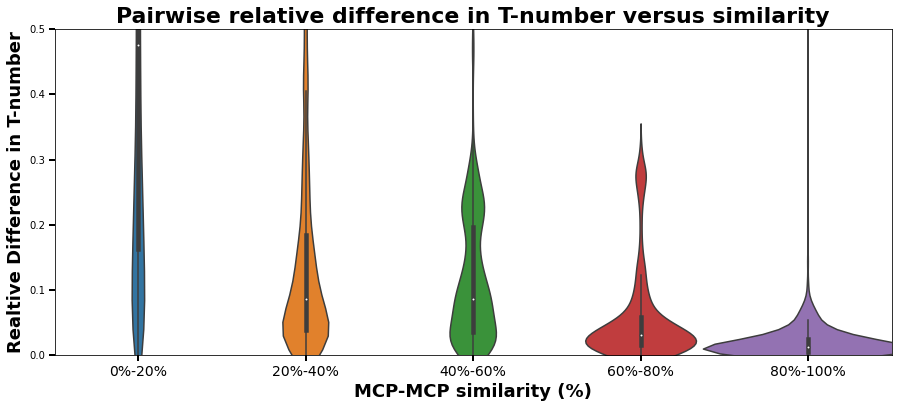

In [72]:
# box plot for evalue=0.001
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
ax = sn.violinplot(x="Similiarity_bracket", y="relative_difference", data=SN_plotdata_e001, width=1.25,)
plt.xlabel("MCP-MCP similarity (%)",fontweight="bold", fontsize=font2) 
plt.ylabel("Realtive Difference in T-number",fontweight="bold", fontsize=font2)
plt.title("Pairwise relative difference in T-number versus similarity",fontweight="bold", fontsize=font1)
plt.ylim(0,.5)
plt.xticks(np.arange(5), ('0%-20%','20%-40%','40%-60%', '60%-80%', '80%-100%'), fontsize=font3)
#ax.patch.set_facecolor('white')
ax.tick_params(length=6, width=2)

#allplotdatan = 0
#plotdatan = []
#for i in range(len(plotdata_e001)):
#    DNAfb = "n=" + str(len(plotdata_e001[i]))
#    plotdatan.append(DNAfb)
#    allplotdatan = allplotdatan+len(plotdata_e001[i])
#    plt.text(i-.5, 4.5, DNAfb, {'fontsize': font2})


In [6]:
tagPcts = ['0%-20%','20%-40%','40%-60%', '60%-80%', '80%-100%']
for i in range(5):
    print(tagPcts[i])
    print(" mean ", np.round(np.mean(plotdata_e001[i]),2), ", median ", np.round(np.median(plotdata_e001[i]),2))
    print(" min ", np.round(np.min(plotdata_e001[i]),2), ", max ", np.round(np.max(plotdata_e001[i]),2))
        

0%-20%
 mean  0.62 , median  0.48
 min  0.0 , max  4.21
20%-40%
 mean  0.14 , median  0.09
 min  0.0 , max  1.97
40%-60%
 mean  0.12 , median  0.09
 min  0.0 , max  0.57
60%-80%
 mean  0.06 , median  0.03
 min  0.0 , max  0.32
80%-100%
 mean  0.02 , median  0.01
 min  0.0 , max  0.7


In [98]:
# sanity check: did we plot all of the pairwise possibilities?
allplotdatan

190036

In [99]:
# count number in MCP db that do not have a T-number prediction
xTx100 = np.asarray([i for i in tNearV if i==0])
len(xTx100)/n

0.20583468395461912

In [21]:
# create an array of similarity percentages by T-number (e-val=0.001)
allT1 = []
allLocs = []
tempT = []
allCount = []
tempCount = 0


for j in tps3:
    tempT = []
    tempCount = 0
    for i in range(669):
        if j == tNearV[i]:
            tempCount = tempCount+1
            tempT.append(i)
    allLocs.append(tempT)
    allCount.append(tempCount)

for i in range(len(tps3)):
    tempT = []
    if len(allLocs[i])==0:
        tempT.append(0)
    else:
        for j in allLocs[i]:
            for k in allLocs[i]:
                if j<k:
                    tempT.append(tProx_e001[j][k])
    allT1.append(tempT)


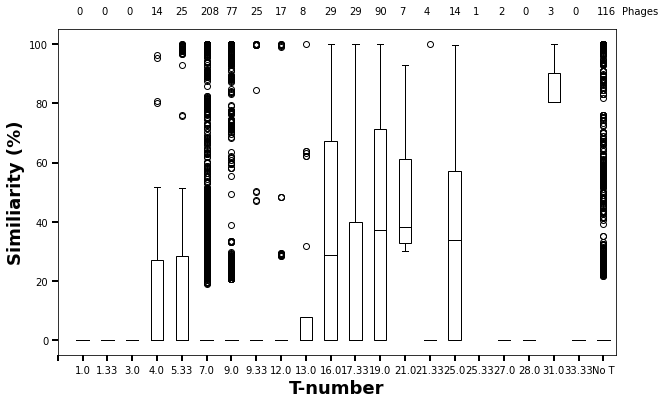

In [135]:
# box plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.boxplot(allT1, patch_artist=True, boxprops=dict(facecolor='white'), medianprops = dict(color="black"))
plt.xlabel("T-number",fontweight="bold", fontsize=font2) 
plt.ylabel("Similiarity (%)",fontweight="bold", fontsize=font2)
#plt.title("Pairwise difference in T-number versus similarity (eVal=1)",fontweight="bold", fontsize=font1)
plt.xticks(np.arange(23), tps4)
ax.patch.set_facecolor('white')
ax.tick_params(length=6, width=2)

for i in range(len(allT1)):
    DNAf2 = str(allCount[i])
    plt.text(i+1-.25, 110, DNAf2)
plt.text(i+2-.25, 110, 'Phages');

plt.savefig("Fig4SI-Tnum vs Similarity.png")
plt.savefig("Fig4SI-Tnum vs Similarity.svg");

In [23]:
# create a list for each line item in the similarity table listing which other phage is most similar (by index)
match_max = []
zero_match= 0
for i in range(n):
# if there is no match, fill the position with an index that doesn't exist (700)
    if (np.max(tProx_e001[i])==0):
        match_max.append(700)
        zero_match = zero_match+1;
    else: 
        match_max.append(np.argmax(tProx_e001[i]));
        
match_max = np.asarray(match_max)

In [24]:
# retrieve the T-number of the similar phage based on the index identified above
match_T = []
for i in match_max:
# if the index doesn't exist, append 0, for No T
    if i>669:
        match_T.append(0)
    else:       
        match_T.append(tNearV[i])
match_T = np.asarray(match_T)

# print the number of phages that had no match using similarity
print("Phages with no matches: ", zero_match)

Phages with no matches:  26


In [25]:
# set train and test sizes
n80 = round(n*.80)
n20 = n-n80

# create a list of the phages by number
phagelist = np.arange(0,n)

# set number of iterations at each percent similarity
n_iter = 10
all_missing = []
all_correct = []

# create a random shuffle of the phage data
shuffle_index = np.random.permutation(n)

# loop 
for k in range(n_iter):

    # create a random shuffle of the phage data for this iteration
    shuffle_index = np.random.permutation(shuffle_index)

    # split into an 80/20 training set
    p80 = phagelist[shuffle_index][:n80]
    p20 = phagelist[shuffle_index][n80:]

    # for each line item in the test set, find the item in the train set that is most similar
    # create a placeholder for the list (from -- to -- sim % -- from T -- to T -- check)
    predict_t20=np.zeros((n20,6))

    # for each item in the test set
    for i in range(len(p20)):
        # add the from phage to the new table
        predict_t20[i][0]=p20[i]
        # for each column (to phage) in tprox
        for j in range(n):
            # if the to phage is in the training set
            if (j in p80):
                # and if the similarity percentage is larger than what was there before (all start at zero)
                if tProx_e001[p20[i]][j] > predict_t20[i][2]:
                    #then update the to phage and similarity percentage in our prediction table
                    predict_t20[i][2]=tProx_e001[p20[i]][j]
                    predict_t20[i][1]=j
        # retrieve the T-number prediction for the from phage
        predict_t20[i][3]=tNearV[int(predict_t20[i][0])]
        # retrieve the T-number prediction for the most similar phage found in the train set
        predict_t20[i][4]=tNearV[int(predict_t20[i][1])]
        # verify whether they match (correct prediction)
        if predict_t20[i][3]==predict_t20[i][4]:
            predict_t20[i][5]=1

    # count the number of from phages that have no match                
    missingpred20 = 0
    for i in predict_t20[:,2]:
        if i ==0:
            missingpred20 = missingpred20 +1
    all_missing.append(missingpred20/n20)

    # count the number of from phages that were predicted correctly                
    correctpred20 = 0
    for i in predict_t20[:,5]:
        if i ==1:
            correctpred20 = correctpred20 +1
    all_correct.append(correctpred20/n20)
    
avg_missing=np.mean(all_missing)
avg_correct=np.mean(all_correct)


In [26]:
print(avg_missing)
print(all_missing)
print(avg_correct)
print(all_correct)

0.05284552845528455
[0.04878048780487805, 0.032520325203252036, 0.04065040650406504, 0.06504065040650407, 0.06504065040650407, 0.04065040650406504, 0.04065040650406504, 0.056910569105691054, 0.056910569105691054, 0.08130081300813008]
0.7
[0.7154471544715447, 0.7317073170731707, 0.6666666666666666, 0.6829268292682927, 0.7479674796747967, 0.7073170731707317, 0.7398373983739838, 0.6829268292682927, 0.6504065040650406, 0.6747967479674797]


In [27]:
# set train and test sizes
n80 = round(n*.80)
n20 = n-n80

stats_acc_all = np.zeros((10,3))

for m in range(10):

    # set number of iterations at each percent similarity
    n_iter = 1000
    all_missing = []
    all_correct = []

    # create a random shuffle of the phage data
    shuffle_index = np.random.permutation(n)

    # loop 
    for k in range(n_iter):

        # create a random shuffle of the phage data for this iteration
        shuffle_index = np.random.permutation(shuffle_index)

        # split into an 80/20 training set
        p80 = phagelist[shuffle_index][:n80]
        p20 = phagelist[shuffle_index][n80:]

        # for each line item in the test set, find the item in the train set that is most similar
        # create a placeholder for the list (from phage -- to phage -- sim % -- from T -- to T -- check)
        predict_t20=np.zeros((n20,6))

        # for each item in the test set
        for i in range(len(p20)):
            # add the from phage to the new table
            predict_t20[i][0]=p20[i]
            # fill the to phage columm so there's no confusion between no prediction and phage #0
            predict_t20[i][1]=-1
            # for each column (to phage) in tprox
            for j in range(n):
                # if the to phage is in the training set
                if (j in p80):
                    # and if the similarity percentage is larger than what was there before (all start at zero) 
                    # AND larger than the threshold
                    if ((tProx_e001[p20[i]][j] > predict_t20[i][2]) and (tProx_e001[p20[i]][j] > m*10)):
                        #then update the to phage and similarity percentage in our prediction table
                        predict_t20[i][2]=tProx_e001[p20[i]][j]
                        predict_t20[i][1]=j
            # retrieve the T-number prediction for the from phage
            predict_t20[i][3]=tNearV[int(predict_t20[i][0])]
            # retrieve the T-number prediction for the most similar phage found in the train set
            predict_t20[i][4]=tNearV[int(predict_t20[i][1])]
            
            # verify whether they match (correct prediction)
            if predict_t20[i][3]==predict_t20[i][4]:
                predict_t20[i][5]=1

        # count the number of from phages that have no match                
        missingpred20 = 0
        for i in predict_t20[:,2]:
            if i ==0:
                missingpred20 = missingpred20 +1
        all_missing.append(missingpred20/n20)

        # count the number of from phages that were predicted correctly                
        correctpred20 = 0
        totalpreds = 0
        for i in range(len(predict_t20[:,5])):
            if (predict_t20[i][1]>=0):
                totalpreds=totalpreds+1
                if (predict_t20[i][5]==1):
                    correctpred20 = correctpred20 +1
                
            
        all_correct.append(correctpred20/totalpreds)

        avg_missing=1-np.mean(all_missing)
        avg_correct=np.mean(all_correct)
        
    stats_acc_all[m][0]=m*10
    stats_acc_all[m][1]=avg_missing
    stats_acc_all[m][2]=avg_correct
    print("loop", m)

print(stats_acc_all)

loop 0
loop 1
loop 2
loop 3
loop 4
loop 5
loop 6
loop 7
loop 8
loop 9
[[ 0.          0.94913008  0.73231099]
 [10.          0.94890244  0.73388998]
 [20.          0.9488374   0.73402214]
 [30.          0.9041626   0.74893434]
 [40.          0.84461789  0.76963972]
 [50.          0.79062602  0.77223578]
 [60.          0.73377236  0.78253982]
 [70.          0.69458537  0.77935004]
 [80.          0.64173984  0.79020558]
 [90.          0.58150407  0.80050236]]


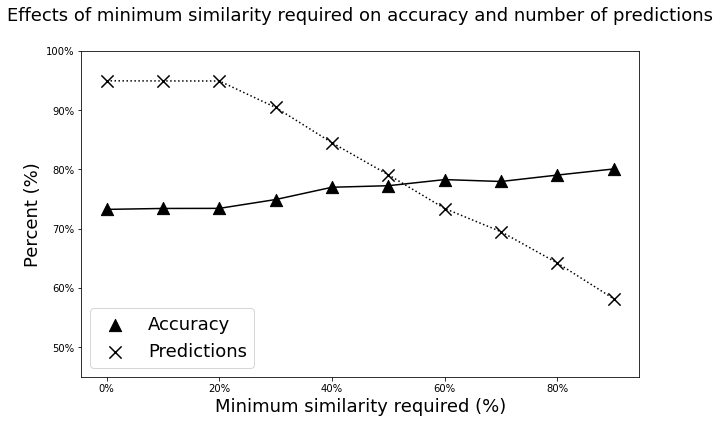

In [109]:
stats_acc_all1 = copy.copy(stats_acc_all) 

from matplotlib.ticker import PercentFormatter

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.set_facecolor('xkcd:white')
plt.scatter(stats_acc_all1[:,0],stats_acc_all1[:,2], 150, color="black", marker="^", label='Accuracy')
plt.plot(stats_acc_all1[:,0],stats_acc_all1[:,2], color="black")
plt.scatter(stats_acc_all1[:,0],stats_acc_all1[:,1], 150, color="black", marker="x", label='Predictions')
plt.plot(stats_acc_all1[:,0],stats_acc_all1[:,1], color="black", linestyle=":")
plt.ylabel('Percent (%)', fontsize=font2)
plt.xlabel('Minimum similarity required (%)', fontsize=font2)
plt.title("Effects of minimum similarity required on accuracy and number of predictions", fontsize=font2, pad=30)
plt.ylim(0.45,1)

plt.legend(loc='lower left', fontsize=font2)

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.xaxis.set_major_formatter(PercentFormatter(xmax=100))

plt.savefig("Fig4c-Similarity vs accuracy and predictions.png")
plt.savefig("Fig4c-Similarity vs accuracy and predictions.svg");

In [29]:
# Filter the tProx table for pairwise similarity within T-numbers

# create placeholders for the similarity data and the count of pairs in each
matchT1=[]
matchTlen=[]

# for each line item in allLocs (each T-number) excluding the phages with no predictions
for i in range(len(allLocs)-1):
    # create a placeholder for the list of similarities
    mt1=[]
    # for each T-number with phages assigned to it
    if len(allLocs[i])>1:
        # for each distinct pair within a T-number, append the similarity to the new list
        for j in allLocs[i]:
            for k in allLocs[i]:
                if j<k:
                    mt1.append(tProx_e001[j][k])
                    
    # else if there are no similarities in a T-number
    else:
        mt1.append(0)
    matchT1.append(mt1)
    matchTlen.append(len(mt1))


In [30]:
matchTlen

[1,
 1,
 1,
 91,
 300,
 21528,
 2926,
 300,
 136,
 28,
 406,
 406,
 4005,
 21,
 6,
 91,
 1,
 1,
 1,
 3,
 1]

In [31]:
# now for each T-number, split the similarities into 20% categories
nn = len(matchT1)
l1=np.zeros((nn,5))
            
for i in range(nn):
    for j in matchT1[i]:
        if (j<=20):
            l1[i][0]=l1[i][0]+1
        if (j>20 and j<=40):
            l1[i][1]=l1[i][1]+1
        if (j>40 and j<=60):
            l1[i][2]=l1[i][2]+1
        if (j>60 and j<=80):
            l1[i][3]=l1[i][3]+1
        if (j>=80):
            l1[i][4]=l1[i][4]+1
            
# and then use the counts to calculate each as a percentage
for i in range(len(l1)):
    l1[i]=l1[i]/matchTlen[i]

print("   0%-20% - - 20%-40% - - 40%-60% - - 60%-80% - - 80%-100%")
print(l1)

   0%-20% - - 20%-40% - - 40%-60% - - 60%-80% - - 80%-100%
[[1.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.58241758 0.31868132 0.05494505 0.01098901 0.03296703]
 [0.73       0.02666667 0.12       0.00666667 0.11666667]
 [0.94634894 0.02624489 0.01361018 0.0039019  0.00989409]
 [0.76555024 0.16131237 0.00307587 0.01913876 0.05092276]
 [0.95333333 0.         0.01333333 0.         0.03333333]
 [0.84558824 0.08823529 0.02205882 0.         0.04411765]
 [0.75       0.03571429 0.         0.17857143 0.03571429]
 [0.46551724 0.10344828 0.08128079 0.18472906 0.16502463]
 [0.65763547 0.091133   0.10098522 0.10837438 0.04187192]
 [0.28639201 0.31810237 0.03620474 0.20049938 0.1588015 ]
 [0.         0.52380952 0.0952381  0.33333333 0.04761905]
 [0.83333333 0.         0.         0.         0.16666667]
 [0.48351648 0.0989011  0.21978022 0.07692308 0.12087912]
 [1.         

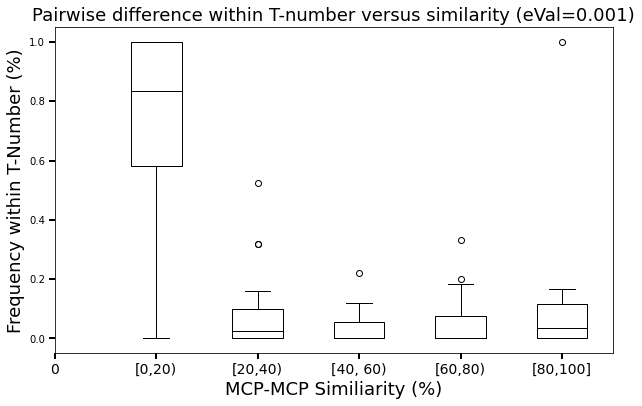

In [32]:
listtest1=copy.copy(l1) 
# box plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.boxplot(listtest1, patch_artist=True, boxprops=dict(facecolor='white'), medianprops = dict(color="black"))
plt.xlabel("MCP-MCP Similiarity (%)", fontsize=font2) 
plt.ylabel("Frequency within T-Number (%)", fontsize=font2)
plt.xticks(np.arange(6), ('0','[0,20)','[20,40)','[40, 60)', '[60,80)', '[80,100]'), fontsize=font3)
plt.title("Pairwise difference within T-number versus similarity (eVal=0.001)", fontsize=font2)
ax.patch.set_facecolor('white')
ax.tick_params(length=6, width=2)

plt.savefig("Fig4d-Similarity percent per T.png")
plt.savefig("Fig4d-Similarity percent per T.svg");

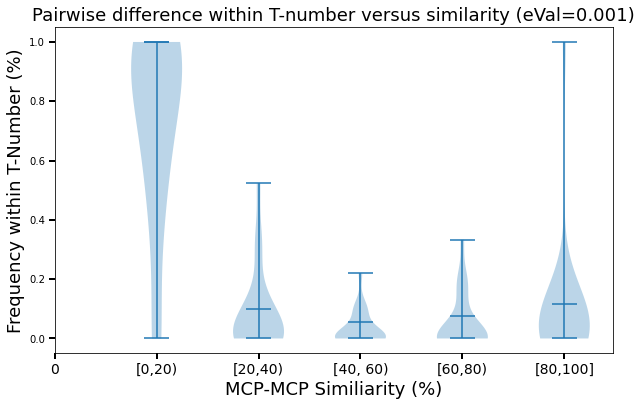

In [18]:
listtest1=copy.copy(l1) 
# box plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.violinplot(listtest1,quantiles=[[.75], [0.75], [0.75], [0.75], [0.75]])
plt.xlabel("MCP-MCP Similiarity (%)", fontsize=font2) 
plt.ylabel("Frequency within T-Number (%)", fontsize=font2)
plt.xticks(np.arange(6), ('0','[0,20)','[20,40)','[40, 60)', '[60,80)', '[80,100]'), fontsize=font3)
plt.title("Pairwise difference within T-number versus similarity (eVal=0.001)", fontsize=font2)
ax.patch.set_facecolor('white')
ax.tick_params(length=6, width=2)

plt.savefig("Fig4d-Similarity percent per T violin.png")
plt.savefig("Fig4d-Similarity percent per T violin.svg");

In [5]:
# save kernel state
# note that all csv_writer functions are commented out, since they cannot be pickled
import dill
dill.dump_session('item3_updated.db')

In [3]:
## load kernel state
## rerun imports cells 1 and 2 as well
#import dill
#dill.load_session('item3_updated.db')